# 在启用Eager Execution的情况下使用RNN生成文本

https://www.tensorflow.org/tutorials/sequences/text_generation
https://github.com/tensorflow/docs/blob/master/site/en/tutorials/sequences/text_generation.ipynb

本教程演示了如何使用基于字符的RNN生成文本。我们将使用Andrej Karpathy在 The Unreasonable Effectiveness of Recurrent Neural Networks一文中提供的莎士比亚作品数据集。我们根据此数据集中的给定字符序列训练一个模型，让它预测序列的下一个字符。通过重复调用该模型，可以生成更长的文本序列。

本教程中包含使用 tf.keras 和Eager Execution实现的可运行代码。

In [2]:
# 导入TensorFlow和其他库
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import os
import time

In [3]:
# 下载莎士比亚数据集
path_to_file = tf.keras.utils.get_file('shakespeare.txt',
                                       'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [4]:
# 读取数据
text = open(path_to_file).read()
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [5]:
# Take a look at the first 1000 characters in text
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [6]:
# The unique characters in the file
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

65 unique characters


In [7]:
# 向量化文本
# 在训练之前，我们需要将字符串映射到数字表示值。
# 创建两个对照表：一个用于将字符映射到数字，另一个用于将数字映射到字符。

# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [8]:
# 现在，每个字符都有一个对应的整数表示值。请注意，我们按从 0 到 len(unique) 的索引映射字符。

for char,_ in zip(char2idx, range(20)):
    print('{:6s} ---> {:4d}'.format(repr(char), char2idx[char]))

'\n'   --->    0
' '    --->    1
'!'    --->    2
'$'    --->    3
'&'    --->    4
"'"    --->    5
','    --->    6
'-'    --->    7
'.'    --->    8
'3'    --->    9
':'    --->   10
';'    --->   11
'?'    --->   12
'A'    --->   13
'B'    --->   14
'C'    --->   15
'D'    --->   16
'E'    --->   17
'F'    --->   18
'G'    --->   19


In [9]:
# Show how the first 13 characters from the text are mapped to integers
print ('{} ---- characters mapped to int ---- > {}'.format(text[:13], text_as_int[:13]))

First Citizen ---- characters mapped to int ---- > [18 47 56 57 58  1 15 47 58 47 64 43 52]


In [10]:
# 预测任务
# 根据给定的字符或字符序列预测下一个字符最有可能是什么？这是我们要训练模型去执行的任务。
# 模型的输入将是字符序列，而我们要训练模型去预测输出，即每一个时间步的下一个字符。

In [11]:
# 创建训练样本和目标
# 将文本划分为训练样本和训练目标。每个训练样本都包含从文本中选取的seq_length个字符。
# 相应的目标也包含相同长度的文本，但是将所选的字符序列向右顺移一个字符。
# 例如，假设seq_length为4，我们的文本为“Hello”，则可以将“Hell”创建为训练样本，
# 将“ello”创建为目标。
# 将文本拆分成文本块，每个块的长度为seq_length+1个字符：

In [12]:
# The maximum length sentence we want for a single input in characters
seq_length = 100

# Create training examples / targets
chunks = tf.data.Dataset.from_tensor_slices(text_as_int).batch(seq_length+1, drop_remainder=True)

for item in chunks.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [13]:
# 接下来，利用此文本块创建输入文本和目标文本

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = chunks.map(split_input_target)

In [14]:
# 我们输出第一个样本的前10个值：

for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target data: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [15]:
# 这些向量的每个索引均作为一个时间步来处理。
# 对于时间步0的输入，我们收到了映射到数字18的字符，并尝试预测映射到数字47的字符。
# 在时间步1，执行相同的操作，但除了当前字符外，还要考虑上一步的信息。

for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 18 ('F')
  expected output: 47 ('i')
Step    1
  input: 47 ('i')
  expected output: 56 ('r')
Step    2
  input: 56 ('r')
  expected output: 57 ('s')
Step    3
  input: 57 ('s')
  expected output: 58 ('t')
Step    4
  input: 58 ('t')
  expected output: 1 (' ')


In [16]:
# 使用tf.data创建批次文本并重排这些批次

# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [17]:
# 模型
# 使用tf.keras模型子类化API创建模型，然后根据需要进行更改。我们可以使用三个层来定义模型：
# 嵌入层：一个可训练的对照表，它会将每个字符的数字映射到具有embedding_dim个维度的高维度向量；
# GRU层：一种层大小等于单位数的RNN。（在此示例中，您也可以使用LSTM层。）
# 密集层：带有vocab_size个单元。

class Model(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, units):
    super(Model, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    if tf.test.is_gpu_available():
      self.gru = tf.keras.layers.CuDNNGRU(self.units,
                                          return_sequences=True,
                                          recurrent_initializer='glorot_uniform',
                                          stateful=True)
    else:
      self.gru = tf.keras.layers.GRU(self.units,
                                     return_sequences=True,
                                     recurrent_activation='sigmoid',
                                     recurrent_initializer='glorot_uniform',
                                     stateful=True)

    self.fc = tf.keras.layers.Dense(vocab_size)

  def call(self, x):
    embedding = self.embedding(x)

    # output at every time step
    # output shape == (batch_size, seq_length, hidden_size)
    output = self.gru(embedding)

    # The dense layer will output predictions for every time_steps(seq_length)
    # output shape after the dense layer == (seq_length * batch_size, vocab_size)
    prediction = self.fc(output)

    # states will be used to pass at every step to the model while training
    return prediction

In [18]:
# 实例化模型、优化器和损失函数

# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
units = 1024

model = Model(vocab_size, embedding_dim, units)

In [19]:
# 我们将使用采用默认参数的 Adam 优化器，并用 softmax 交叉熵作为损失函数。

# Using adam optimizer with default arguments
optimizer = tf.train.AdamOptimizer()

# Using sparse_softmax_cross_entropy so that we don't have to create one-hot vectors
def loss_function(real, preds):
    return tf.losses.sparse_softmax_cross_entropy(labels=real, logits=preds)

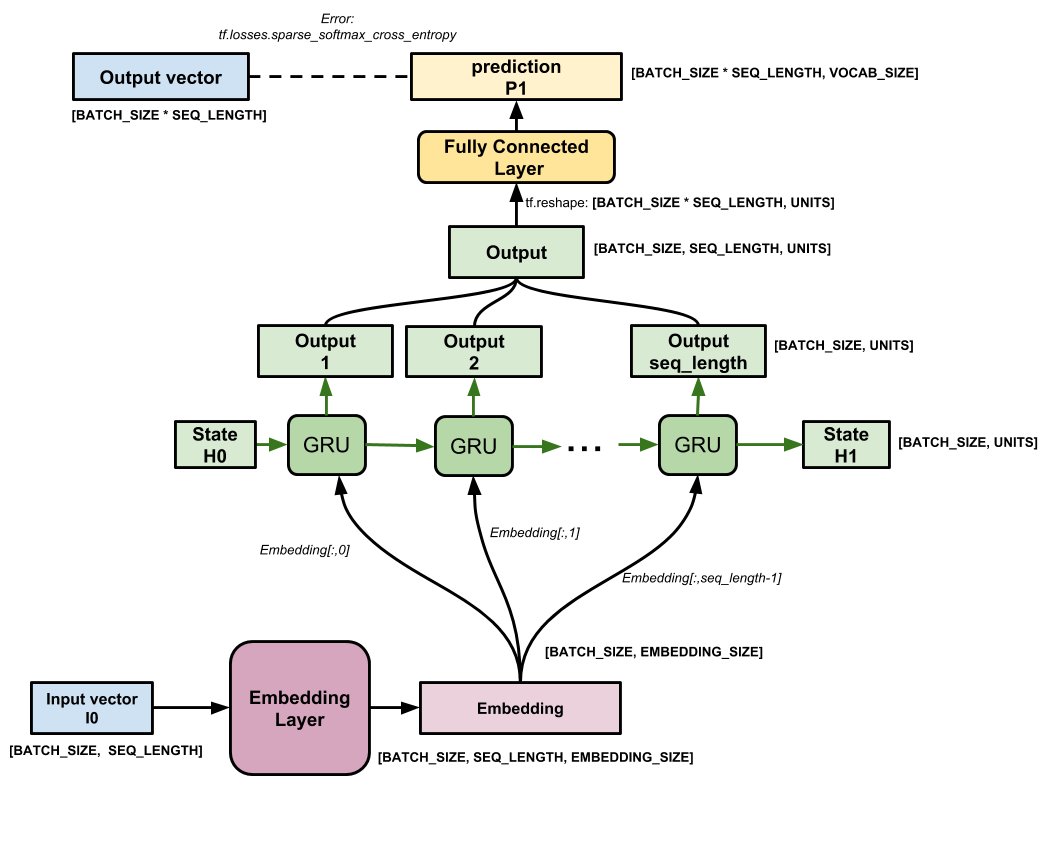

In [ ]:
model.build(tf.TensorShape([BATCH_SIZE, seq_length]))

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  16640     
_________________________________________________________________
gru (GRU)                    multiple                  3935232   
_________________________________________________________________
dense (Dense)                multiple                  66625     
Total params: 4,018,497
Trainable params: 4,018,497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [ ]:
EPOCHS = 5

# Training loop
for epoch in range(EPOCHS):
    start = time.time()

    # initializing the hidden state at the start of every epoch
    # initally hidden is None
    hidden = model.reset_states()

    for (batch, (inp, target)) in enumerate(dataset):
          with tf.GradientTape() as tape:
              # feeding the hidden state back into the model
              # This is the interesting step
              predictions = model(inp)
              loss = loss_function(target, predictions)

          grads = tape.gradient(loss, model.variables)
          optimizer.apply_gradients(zip(grads, model.variables))

          if batch % 100 == 0:
              print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch+1,
                                                            batch,
                                                            loss))
    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
      model.save_weights(checkpoint_prefix)

    print ('Epoch {} Loss {:.4f}'.format(epoch+1, loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.1747
